In [6]:
import pandas as pd
import numpy as np
from github import Github
import github
import time
import urllib
from datetime import datetime
import re
import matplotlib.pyplot as plt

# NYC COVID Death Delays

Recently on twitter, there has been a lot of speculation that NYC has almost reached the point of having single digit or zero daily deaths.

This speculation is largely based on some visualizations on NYC's [COVID-19 Data](https://www1.nyc.gov/site/doh/covid/covid-19-data.page) page.

The charts presented here present an extremely optimistic view of things, as data delays have contributed substantially to the curve looking steeper on the downward descent than it actually is.

Those [watching closely](https://twitter.com/edpalermoRPI/status/1258785199581794304) noticed how asymmetric the counts were early on, but this pattern has continued. The values in the NYC.gov chart are deceptive, and continue to be. 



In [8]:
g = Github() # Add your authentication or Oauth here in order to get sufficient rate access. Otherwise, the following cell will fail
r = g.get_repo('nychealth/coronavirus-data')

In [10]:
sha_list = []
i = 0
for commit in r.get_commits():
    sha_list.append([commit.commit.committer.date, commit.commit.sha])
    i = i + 1
df = pd.DataFrame(sha_list, columns=['date', 'sha'])
df = df.set_index('date').groupby(pd.Grouper(freq='D')).last()['2020-03-31':]

In [12]:
confirmed_at_date = []
probable_at_date = []
sum_at_date = []
deaths_official = []
for date, sha in df.sha.iteritems():
    try:
        date_data = pd.read_csv(
            f'https://raw.githubusercontent.com/nychealth/coronavirus-data/{sha}/Deaths/probable-confirmed-dod.csv',
            index_col='date_of_death', parse_dates=True
        ).fillna(0)
        confirmed_at_date.append(date_data.CONFIRMED_COUNT.rename(date))
        probable_at_date.append(date_data.PROBABLE_COUNT.rename(date))
        sum_at_date.append(date_data.sum(axis=1).rename(date))
    except urllib.error.HTTPError:
        pass
    try:
        do = pd.read_csv(
            f'https://raw.githubusercontent.com/nychealth/coronavirus-data/{sha}/case-hosp-death.csv',parse_dates=True
        )
        d2 = do
        do = do.rename({do.columns[0]: 'date'}, axis=1).set_index('date').iloc[:,2] # DEATHS
        do.index = pd.DatetimeIndex(do.index)
        do = do.reindex(do.index.drop_duplicates(keep='first'))
        deaths_official.append(do.rename(date))
    except urllib.error.HTTPError:
        pass
    except KeyError:
        pass

In [14]:
deaths = pd.concat(deaths_official, axis=1).T

In [16]:
confirmed = pd.concat(confirmed_at_date, axis=1).T
probable = pd.concat(probable_at_date, axis=1).T
possible = pd.concat(sum_at_date, axis=1).T

In [18]:
first_death = deaths.iloc[-1][(deaths.iloc[-1] > 0)].idxmin()
deaths = deaths.loc[:, first_death:].fillna(0)

### NYC COVID-19 deaths show substantial underreporting over time

Can we build a model that corrects for that?

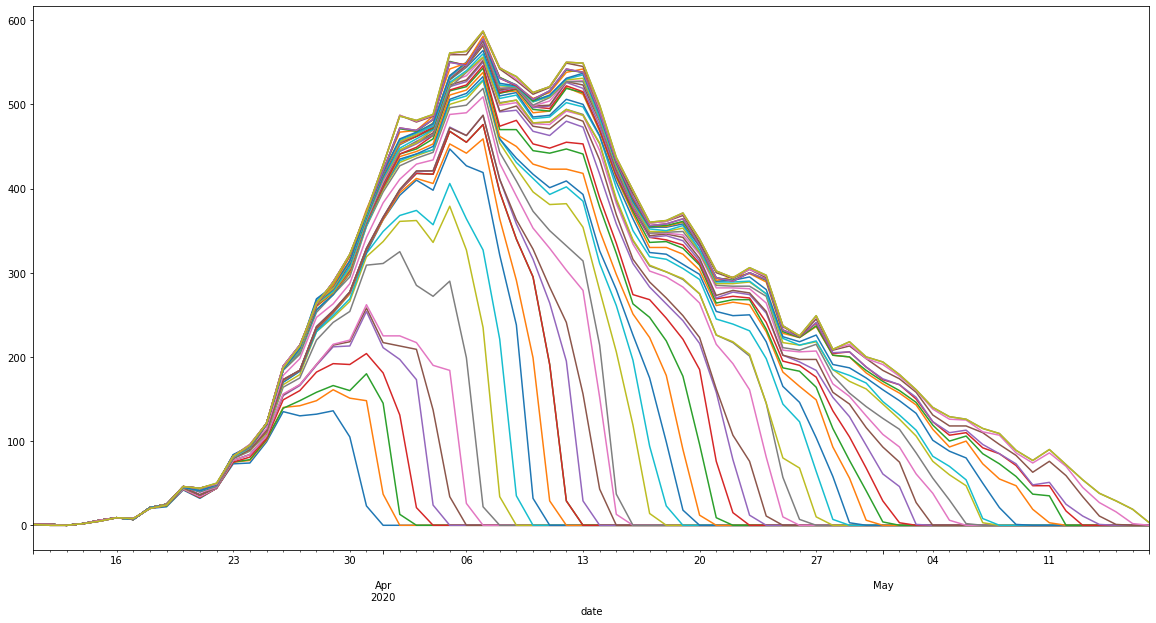

In [20]:
deaths.T.plot(figsize=(20, 10), legend=False)

What %age of cumulative deaths we now know to have occurred by a given date were known at that date?

These numbers are going to converge to 1, but that is because we don't know how much we need to correct the more recent dates!

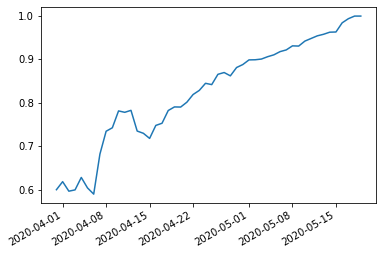

In [22]:
cumulative_deaths = deaths.cumsum(axis=1).apply(lambda x: x.where((x.index < x.name), np.nan), axis=1)
(cumulative_deaths / cumulative_deaths.iloc[-1]).apply(lambda x: x.loc[x.last_valid_index()], axis=1).plot()

How many days on average does it take for a date to get to x% of its eventual deaths?

Let's smooth with a nice gaussian kernel first, as it will prevent noise from making a huge difference in the model.

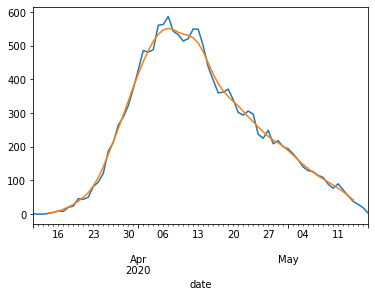

In [24]:
deaths.iloc[-1].plot()
smoothed_deaths = deaths.rolling(7, win_type='gaussian', axis=1, center=True).mean(std=2)
smoothed_deaths.iloc[-1].plot()

In [26]:
days_to_exceed = []
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]:
    exceeded = ((smoothed_deaths / smoothed_deaths.iloc[-1]) > threshold).apply(lambda x: x[x].first_valid_index())
    exceeded = (exceeded - exceeded.index).dt.days
    exceeded.name = threshold
    days_to_exceed.append(exceeded)
days_to_exceed = pd.concat(days_to_exceed, axis=1)

In [ ]:
days_to_exceed.plot(figsize=(10, 5))

Use a window of days where the data seems robust & similar to recent trends (and isn't in the period where the data has not yet reached at least 80% of expected)

,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.85,0.90,0.95,0.99
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.045455,1.136364,1.954545,2.772727,3.772727,4.727273,6.181818,8.545455,11.000000,14.545455,21.909091,36.318182
std,0.652998,0.774317,0.652998,0.528413,0.685344,0.882735,1.180652,1.223861,0.755929,1.223861,3.022284,6.236501
min,-1.000000,0.000000,1.000000,2.000000,2.000000,3.000000,4.000000,6.000000,10.000000,12.000000,17.000000,26.000000
25%,0.000000,1.000000,2.000000,2.250000,3.250000,4.250000,5.250000,8.000000,10.250000,14.000000,19.250000,31.250000
50%,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,7.000000,9.000000,11.000000,14.000000,22.000000,36.500000
75%,0.000000,2.000000,2.000000,3.000000,4.000000,5.000000,7.000000,9.000000,11.750000,15.000000,24.500000,41.750000
max,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,8.000000,10.000000,12.000000,17.000000,27.000000,46.000000


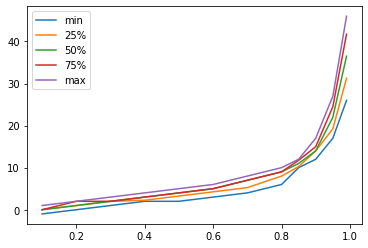

In [29]:
dist = days_to_exceed.loc['03-30-20': '04-20-20'].describe()
dist.loc[['min', '25%', '50%', '75%', 'max']].T.plot()
dist

Lets approximate how what fraction of cases are reported at days n days in the past using a pareto distribution (where we assume anything under 20% reporting is a bad fit, even though this results in negative counts at the beginning), and we add an extra point 50 days out assuming that .9999% of cases are found by then.

We use the upper quartile, as this is more likely accurate given the exponential nature of things.

In [ ]:
def func_pareto(x, a, b, c0):
    return c0 - (b/(x*a)) ** a

def calc_correction(x, params=popt):
    return np.clip(func_pareto(x, *params), 0, 1) 

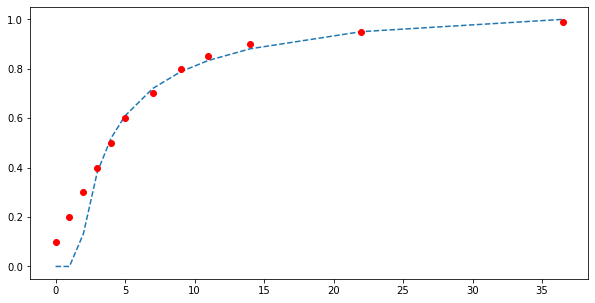

In [32]:
x = (dist.loc['50%']).reset_index() 
x_fit = x[x.iloc[:, 0] >= .4].drop_duplicates(keep='first', subset='50%')
# x_fit = x_fit.append(pd.DataFrame([[50, .99]], columns=['50%', 'index']), ignore_index=True)
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func_pareto, x_fit.iloc[:, 1], x_fit.iloc[:,0], maxfev=2000)

plt.figure(figsize=(10, 5))
plt.plot(x.iloc[:,1], calc_correction(x.iloc[:, 1], params=popt), '--')
plt.plot(x.iloc[:,1], x.iloc[:,0], 'ro')
plt.show()

In [34]:
def correct_data(data):
    date = data.name
    latest = pd.DataFrame(data)
    latest = latest.assign(
        days_in_past=(date - latest.index).days
    ).rename({date: 'deaths'}, axis=1)
    corrected = (latest.deaths / calc_correction(latest.days_in_past, params=popt))
    # Days before 2 days out are predicted poorly here because of the pareto intercept
    corrected[date - pd.Timedelta(days=3):] = np.nan
    return corrected

Lets look at how well this does with data from 10 days ago (pretty well, though that is partly because it was fit on this data to some degree!

It actually underpredicts some recent days, potentially due to the poor fit in small date difference or due to stochasticity.

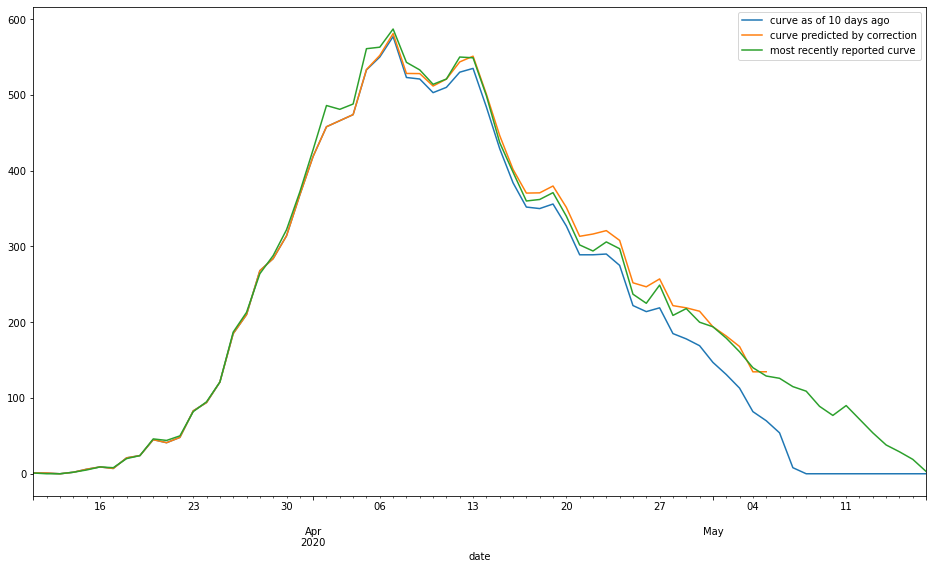

In [36]:
corre = deaths.apply(correct_data, axis=1).T
ten_day_correction = pd.concat([deaths.iloc[-10], corre.iloc[:,-10], deaths.iloc[-1]], axis=1)
ten_day_correction.columns = ['curve as of 10 days ago', 'curve predicted by correction', 'most recently reported curve']
ten_day_correction.plot(figsize=(16, 9))

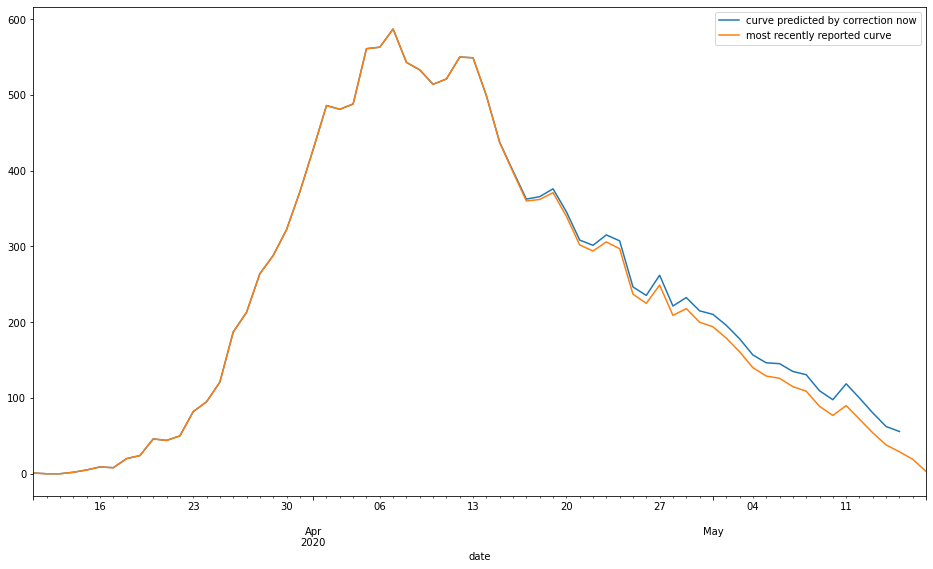

In [38]:
current_correction = pd.concat([corre.iloc[:,-1], deaths.iloc[-1]], axis=1)
current_correction.columns = ['curve predicted by correction now', 'most recently reported curve']
current_correction.plot(figsize=(16, 9))

How many deaths are missing from the cumulative count as of today from the 12th backward? Keep in mind that this number does not include missing deaths from 05-13 - 05-17, which are likely much larger. The overall missing deaths may be ~900 or more (especially given the correction factor)

2020-05-15 00:00:00
Missing deaths:  449.0


<Figure size 432x288 with 0 Axes>

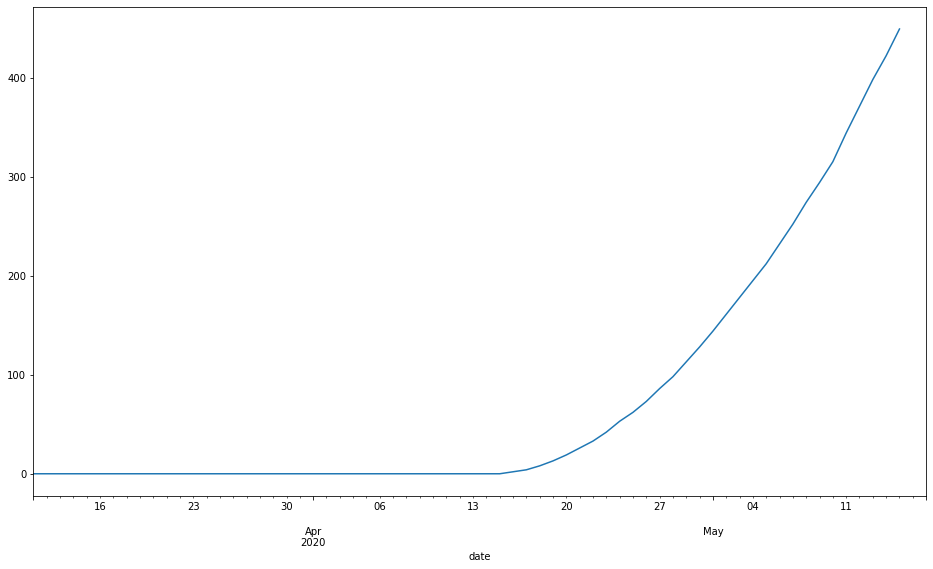

<Figure size 432x288 with 0 Axes>

In [40]:
print(corre.iloc[:,-1].last_valid_index())
print('Missing deaths: ', np.round((corre.iloc[:,-1] - deaths.iloc[-1]).cumsum()).loc[corre.iloc[:,-1].last_valid_index()])
np.round((corre.iloc[:,-1] - deaths.iloc[-1]).cumsum()).plot(figsize=(16, 9))
plt.figure()

After 04-15, the corrected deaths seems to be a pretty smooth exponential decay. Can we use that to predict actual death counts going forward (assuming that there are no new superspreaders?)

Lets just use a simple model.

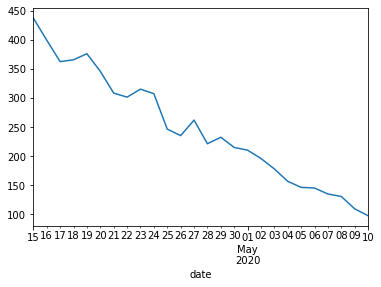

In [42]:
corre.iloc[:,-1].loc['2020-04-15':'2020-05-10'].plot()

In [44]:
section = corre.iloc[:,-1].loc['2020-04-15':'2020-05-10']
(section / section.shift(1)).describe()

count    25.000000
mean      0.944413
std       0.071773
min       0.802072
25%       0.907295
50%       0.931524
75%       0.978376
max       1.113306
Name: 2020-05-19 00:00:00, dtype: float64

Deaths are going down ~7% every day. This will likely be harder to maintain over time, but lets be optimistic!

In [46]:
pred = pd.Series(np.round(corre.iloc[:,-1].loc['2020-04-15'] * np.power(.93, np.arange(1, 301))), index=pd.date_range('2020-04-15', periods=300))

In [48]:
pred.loc['2020-05-14':].cumsum()

2020-05-14     50.0
2020-05-15     96.0
2020-05-16    139.0
2020-05-17    179.0
2020-05-18    216.0
              ...  
2021-02-04    705.0
2021-02-05    705.0
2021-02-06    705.0
2021-02-07    705.0
2021-02-08    705.0
Freq: D, Length: 271, dtype: float64

In [50]:
print(pd.concat([np.round((corre.iloc[:,-1] - deaths.iloc[-1])).loc[:'2020-05-13'], pred.loc['2020-05-14':]]).cumsum().loc['2020-05-16'])
pd.concat([np.round((corre.iloc[:,-1] - deaths.iloc[-1])).loc[:'2020-05-13'], pred.loc['2020-05-14':]]).cumsum()

537.0


2020-03-11       0.0
2020-03-12       0.0
2020-03-13       0.0
2020-03-14       0.0
2020-03-15       0.0
               ...  
2021-02-04    1103.0
2021-02-05    1103.0
2021-02-06    1103.0
2021-02-07    1103.0
2021-02-08    1103.0
Freq: D, Length: 335, dtype: float64

Overall, this simple model predicts an addition ~1180 confirmed deaths in NYC, even if social distancing is not lifted. About ~610 of these are ones that will be retrospectively added (i.e they already occurred but have not been counted as COVID deaths), but at least another ~570 deaths that have not yet occurred are still likely in the first wave.

Interestingly, when looking at probable + confirmed deaths, the same pattern of undercounting is not as present - it seems like many of the added cases are probables turning into confirms (with a ~5 day delay).

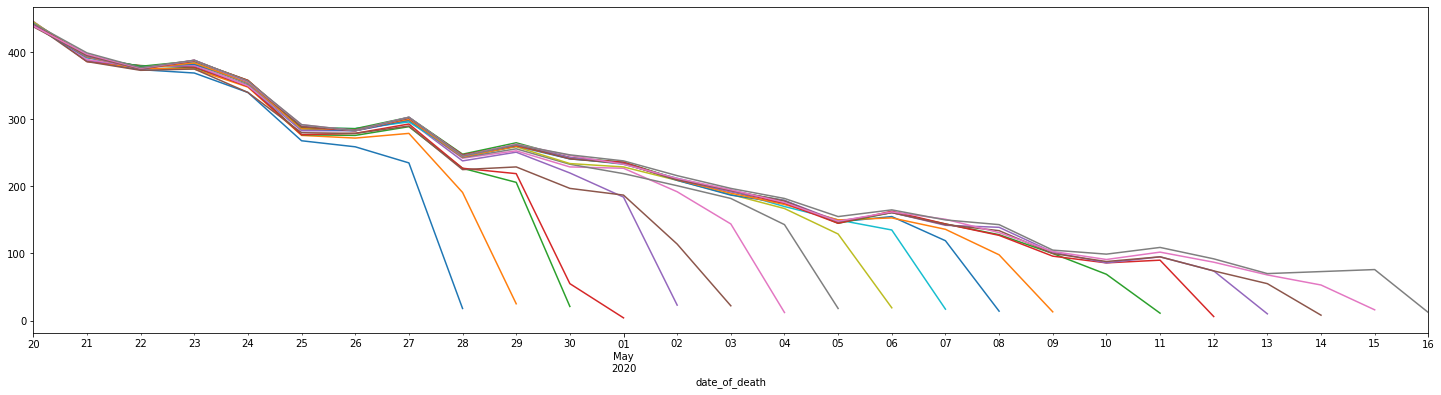

In [52]:
possibilities = possible.T.loc['2020-04-20':]
possibilities.plot(figsize=(25,6),legend=False)

Most (probable + confirmed) counts seem to reach 80% within 4 days, though it is possible this is just poor capturing of possible deaths recently; that data seems to be updated less frequently.

In [54]:
check = ((possibilities.T / possibilities.iloc[:,-1]) > .8).apply(lambda x: x[x > 0].first_valid_index())

In [56]:
(check - check.index).dt.days.describe()

count    27.000000
mean      3.592593
std       1.886373
min       1.000000
25%       3.000000
50%       3.000000
75%       4.000000
max       9.000000
dtype: float64

So, lets see if there is a pattern between our eventual counts and possible counts

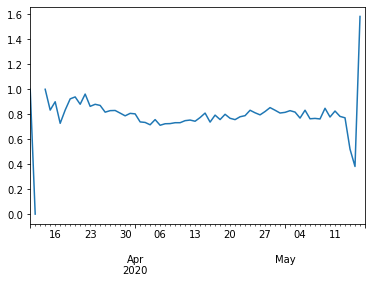

In [58]:
(deaths.iloc[-1]/possible.iloc[-1]).plot()

Deaths seem to converge to the 70-85% of the probable counts quite consistently as of late, though this underpredicts the most severe time.

However, when looking a little closer, this seems to have varied over time - 30 days back, the cumulative sum of deaths was outside the bounds of that cone.

It is entirely possible that the process of qualifying deaths as probable has changed over time:
    - It could be the case that the criteria for 'probable' is getting higher or lower
    - It could be the case that more or fewer of the 'probable' cases are converting to confirmed cases

In [60]:
(deaths.iloc[-1]/possible.iloc[-1])['03-30-20':'05-10-20'].describe()

count    42.000000
mean      0.778857
std       0.038414
min       0.711757
25%       0.749779
50%       0.775711
75%       0.809602
max       0.853061
dtype: float64

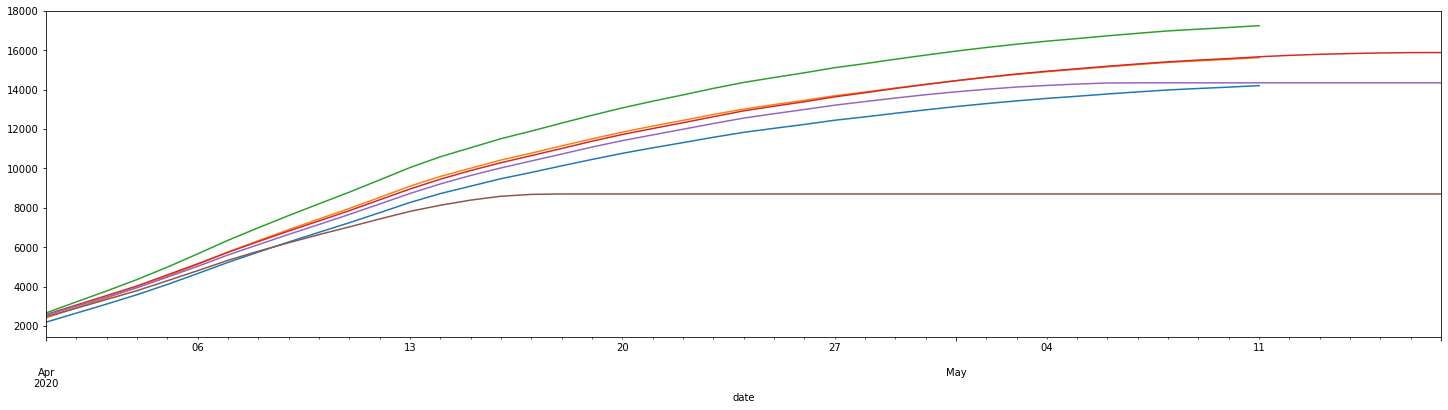

In [62]:
(possible.iloc[-1] * .7).iloc[:-5].cumsum().loc['2020-04-01':].plot(figsize=(25,6))
(possible.iloc[-1] * .77).iloc[:-5].cumsum().loc['2020-04-01':].plot()
(possible.iloc[-1] * .85).iloc[:-5].cumsum().loc['2020-04-01':].plot()
deaths.iloc[-1].cumsum().loc['2020-04-01':].plot()
deaths.iloc[-10].cumsum().loc['2020-04-01':].plot()
deaths.iloc[-30].cumsum().loc['2020-04-01':].plot()

It's possible that we could build a more detailed statistical model to try to capture some of the heteroskedasticity here, but we'd likely need to build a structured regression model; we care less about the cumulative deaths and more about how those deaths are distributed in time. We'll leave this as a later exercise.